In [36]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, LSTM, GRU, SimpleRNN, Embedding, Conv1D, MaxPooling1D, Masking
from keras import optimizers,regularizers
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [37]:
def create_dataset(data, n_steps):
    X_train, Y_train= list(), list()
    final_choices = [x[-1] for x in data]
    features = [x[:-1] for x in data]
    # making training data 
    count = 0
    for feat,f_choice in zip(features, final_choices):
        if(len(feat)//2 < n_steps):
            X_train.append(feat)
            Y_train.append(f_choice)
            count += 1
        else:
            for i in range(len(feat)//2-n_steps):
                end_idx = 2*(i+n_steps)
                X_train.append(feat[2*i:end_idx])
                Y_train.append(feat[end_idx])
            X_train.append(feat[(len(feat)-2*n_steps):len(feat)])
            Y_train.append(f_choice)
    print(count)
    return X_train, Y_train

In [38]:
def create_dataset_test(data, n_steps):
    X_test, Y_test= list(), list()
    final_choices = [x[-1] for x in data]
    features = [x[:-1] for x in data]
    # making training data 
    count = 0
    for feat,f_choice in zip(features, final_choices):
        if(len(feat)//2 < n_steps):
            X_test.append(feat)
            Y_test.append(f_choice)
            count += 1
        else:
            X_test.append(feat[(len(feat)-2*n_steps):len(feat)])
            Y_test.append(f_choice)
    print(count)
    return X_test, Y_test

In [39]:
def normalise_outcomes(data):
    maxi = max([max(x) for x in data])
    mini = min([min(x) for x in data])
    for i in range(len(data)):
        for j in range(1,len(data[i]),2):
            data[i][j] -= mini
            data[i][j] /= (maxi-mini)

In [40]:
def parse_dataset(name, n_steps, flag):
    infile = open(name, 'r')
    lines = infile.readlines()
    data = []
    for line in lines:
        data.append([float(x) for x in line.split(',')])
#     normalise_outcomes(data)
    if(flag):
        return create_dataset(data, n_steps)
    else:
        return create_dataset_test(data, n_steps)

In [41]:
n_steps=10
X_train, y_train = parse_dataset('data/estimation_without_padding.csv',n_steps, 1)
X_test, y_test = parse_dataset('data/competition_without_padding.csv',n_steps, 0)

615
517


In [42]:
y_train = np.array(y_train)
y_test = np.array(y_test)
# y_train -= 1
# y_test -= 1

maxlen = max(max([len(x) for x in X_train]), max([len(x) for x in X_test]))
X_train = pad_sequences(X_train, padding='pre', value=0, dtype=float, maxlen=maxlen)
X_test = pad_sequences(X_test, padding='pre', value=0, dtype=float, maxlen=maxlen)
maxlen


20

In [43]:
X_train[0]

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  1. , -0.3,  2. , -0.3,  1. , -0.3])

In [44]:
X_train = np.reshape(X_train, (X_train.shape[0], n_steps, 2))
X_test = np.reshape(X_test, (X_test.shape[0], n_steps, 2))
X_train[0]

array([[ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 1. , -0.3],
       [ 2. , -0.3],
       [ 1. , -0.3]])

In [45]:
model = Sequential()
model.add(Masking(mask_value=-100.0, input_shape=(None, 2)))
model.add(LSTM(10, return_sequences=False, activation='relu', input_shape=(None, X_train.shape[2])))
# model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

In [46]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
X_train.shape, X_test.shape

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_3 (Masking)          (None, None, 2)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                520       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 33        
Total params: 553
Trainable params: 553
Non-trainable params: 0
_________________________________________________________________


((6116, 10, 2), (1198, 10, 2))

In [47]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=20)

Train on 6116 samples, validate on 1198 samples
Epoch 1/100
6116/6116 [==============================] - 7s 1ms/step - loss: 0.9898 - acc: 0.5885 - val_loss: 0.7490 - val_acc: 0.4925
Epoch 2/100
6116/6116 [==============================] - 5s 868us/step - loss: 0.6272 - acc: 0.6512 - val_loss: 0.7270 - val_acc: 0.5317
Epoch 3/100
6116/6116 [==============================] - 5s 865us/step - loss: 0.5872 - acc: 0.6916 - val_loss: 0.7116 - val_acc: 0.5651
Epoch 4/100
6116/6116 [==============================] - 6s 914us/step - loss: 0.5490 - acc: 0.7224 - val_loss: 0.7285 - val_acc: 0.5860
Epoch 5/100
6116/6116 [==============================] - 6s 957us/step - loss: 0.5271 - acc: 0.7529 - val_loss: 0.7473 - val_acc: 0.5701
Epoch 6/100
6116/6116 [==============================] - 6s 986us/step - loss: 0.5145 - acc: 0.7639 - val_loss: 0.7468 - val_acc: 0.5835
Epoch 7/100
6116/6116 [==============================] - 6s 941us/step - loss: 0.5081 - acc: 0.7659 - val_loss: 0.7464 - val_acc: 0.

6116/6116 [==============================] - 8s 1ms/step - loss: 0.4498 - acc: 0.8172 - val_loss: 0.8203 - val_acc: 0.5726
Epoch 61/100
6116/6116 [==============================] - 7s 1ms/step - loss: 0.4465 - acc: 0.8197 - val_loss: 0.8236 - val_acc: 0.5718
Epoch 62/100
6116/6116 [==============================] - 5s 848us/step - loss: 0.4483 - acc: 0.8203 - val_loss: 0.8234 - val_acc: 0.5626
Epoch 63/100
6116/6116 [==============================] - 5s 848us/step - loss: 0.4469 - acc: 0.8228 - val_loss: 0.8277 - val_acc: 0.5693
Epoch 64/100
6116/6116 [==============================] - 5s 853us/step - loss: 0.4485 - acc: 0.8223 - val_loss: 0.8074 - val_acc: 0.5768
Epoch 65/100
6116/6116 [==============================] - 6s 963us/step - loss: 0.4441 - acc: 0.8228 - val_loss: 0.8102 - val_acc: 0.5743
Epoch 66/100
6116/6116 [==============================] - 7s 1ms/step - loss: 0.4451 - acc: 0.8242 - val_loss: 0.8640 - val_acc: 0.5618
Epoch 67/100
6116/6116 [=============================

In [48]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 56.84%


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


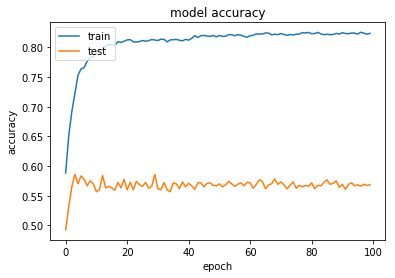

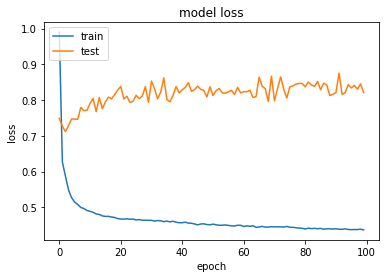

In [49]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
%%script false
1, 59.02
2, 52.25
3, 53.01
5, 56.59
10, 57.60
20, 54.84

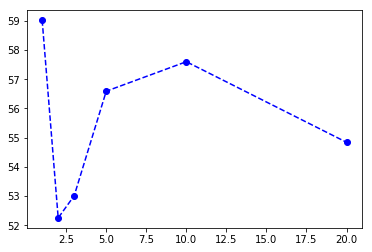

In [16]:
x=[1,2,3,5,10,20]
y=[59.02, 52.25, 53.01, 56.59, 57.60, 54.84]
plt.plot(x,y, '--bo')